In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

import functools as f

%matplotlib inline

In [2]:
BATCH_SIZE = 64
EPOCHS = 20
RHO = 0.05

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=12000, transform=mnist_transform, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10, use_tanh=False):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
        self.use_tanh = use_tanh
    
    def forward(self, x):
        x = F.tanh(self.fc1(x)) if self.use_tanh else F.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [5]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, simplify_rho=False, tanh=False, l1=None, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size, tanh)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
        self.simplify_rho = simplify_rho
        self.use_tahn = tanh
        self.use_l1 = l1 is not None
        self.l1_rate = l1
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        self.d_weights = self.D.fc1.weight
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        def clip(value):
            return torch.clamp(value, 1e-5, 1)
        
        if self.simplify_rho:
            dkl = -rho * torch.log(clip(self.data_rho)) - (1-rho) * torch.log(clip(1-self.data_rho))
        else:
            dkl = -torch.log(clip(self.data_rho/rho)) * rho - torch.log(clip((1-self.data_rho)/(1-rho))) * (1-rho)
        
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def l1_penalty(self):
        return self.l1_rate * torch.abs(self.d_weights.data).sum()
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [6]:
def train(epoch, models, log=None, print_log=True):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(RHO)
            loss = model.loss(output, data) + (model.l1_penalty() if model.use_l1 else rho_loss)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0 and print_log:
            line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        if print_log:
            print(line + losses)

In [7]:
avg_lambda = lambda l: "loss: {:.4f}".format(l)
rho_lambda = lambda p: "rho_loss: {:.4f}".format(p)
line = lambda i, l, p: "{}: ".format(i) + avg_lambda(l) + "\t" + rho_lambda(p)
    
def test(models, loader, epoch, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item()
                rho_loss[k] += m.rho_loss(RHO, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = "\n".join([line(k, test_loss[k], rho_loss[k]) for k in models]) + "\n"
    report = "Loss on test after {} epoch:\n".format(epoch) + lines        
    print(report)

In [8]:
models = {
            "original": Net(BATCH_SIZE), 
            "simplified": Net(BATCH_SIZE, simplify_rho=True),
            "l1_tanh": Net(BATCH_SIZE, l1=0.01, tanh=True)
         }

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
for epoch in range(1, EPOCHS+1):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, False)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

Loss on test after 1 epoch:
original: loss: 0.3710	rho_loss: 0.0020
simplified: loss: 0.3255	rho_loss: 0.0048
l1_tanh: loss: 0.2366	rho_loss: 0.0289

Loss on test after 2 epoch:
original: loss: 0.2693	rho_loss: 0.0016
simplified: loss: 0.2333	rho_loss: 0.0043
l1_tanh: loss: 0.1753	rho_loss: 0.0255

Loss on test after 3 epoch:
original: loss: 0.2247	rho_loss: 0.0013
simplified: loss: 0.1905	rho_loss: 0.0040
l1_tanh: loss: 0.1386	rho_loss: 0.0248

Loss on test after 4 epoch:
original: loss: 0.1966	rho_loss: 0.0011
simplified: loss: 0.1664	rho_loss: 0.0039
l1_tanh: loss: 0.1142	rho_loss: 0.0248

Loss on test after 5 epoch:
original: loss: 0.1759	rho_loss: 0.0010
simplified: loss: 0.1489	rho_loss: 0.0037
l1_tanh: loss: 0.0968	rho_loss: 0.0250

Loss on test after 6 epoch:
original: loss: 0.1597	rho_loss: 0.0008
simplified: loss: 0.1376	rho_loss: 0.0036
l1_tanh: loss: 0.0840	rho_loss: 0.0248

Loss on test after 7 epoch:
original: loss: 0.1468	rho_loss: 0.0007
simplified: loss: 0.1277	rho_los

In [10]:
def plot_results(data, model):
    output = model(data)
    to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
    
    with torch.no_grad():
        encoded = model.E(data.view(-1, 28*28))
        encoded[encoded < 0.5] = 0.
        decoded_f = model.decode(encoded)
        f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
    
    decoded = model.decode(torch.eye(BATCH_SIZE))
    dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
    
    print("Original pics")
    plot_mnist(data.data.numpy(), (8, 8))
    print("Encoded and restored")
    plot_mnist(to_plot, (8, 8))
    print("Restored with <0.5 -> 0.0 coercing after encoding")
    plot_mnist(f_to_plot, (8, 8))
    print("Restored from an identity matrix")
    plot_mnist(dec_to_plot, (8, 8))

Original pics


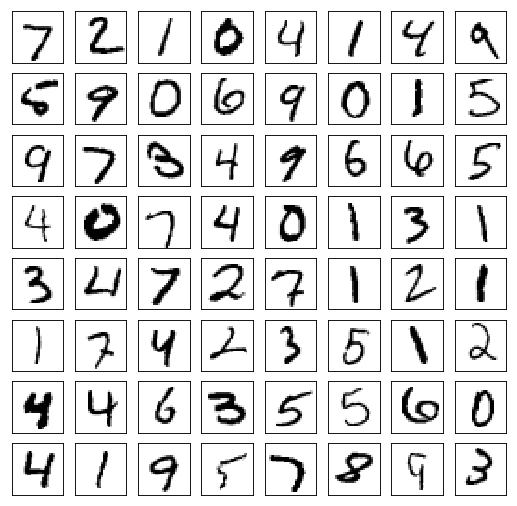

Encoded and restored


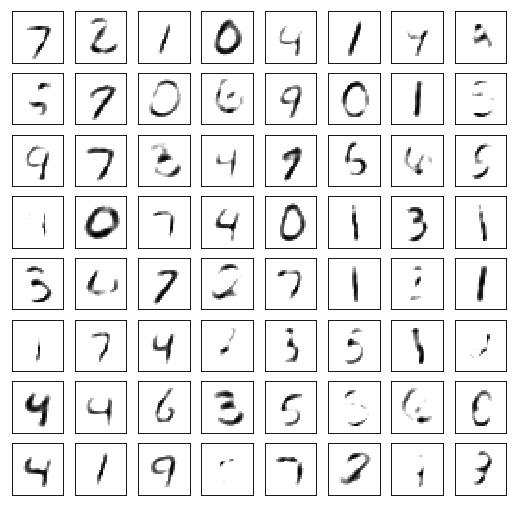

Restored with <0.5 -> 0.0 coercing after encoding


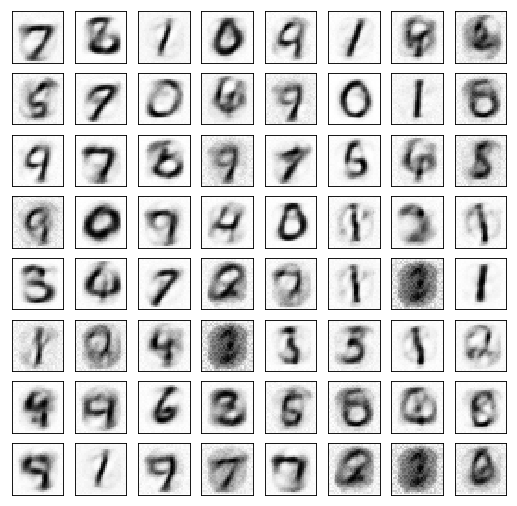

Restored from an identity matrix


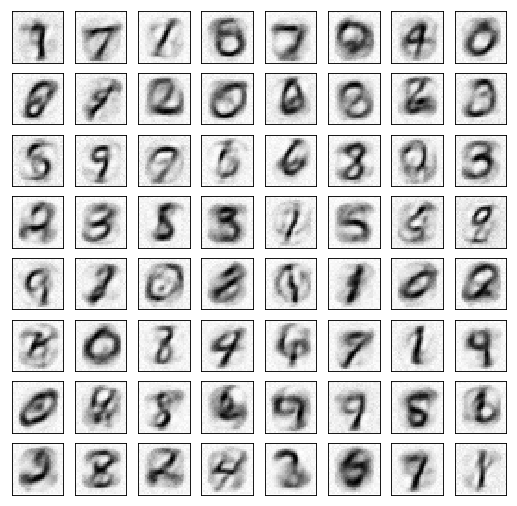

In [11]:
plot_results(next(iter(test_loader))[0], models["original"])

Original pics


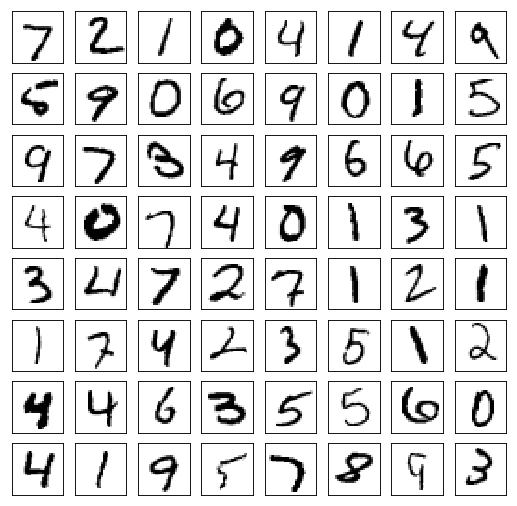

Encoded and restored


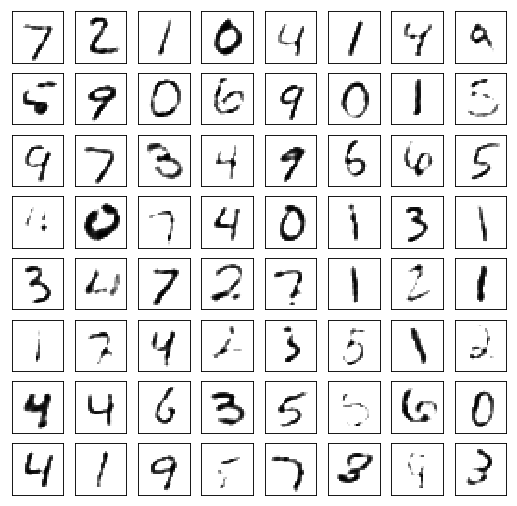

Restored with <0.5 -> 0.0 coercing after encoding


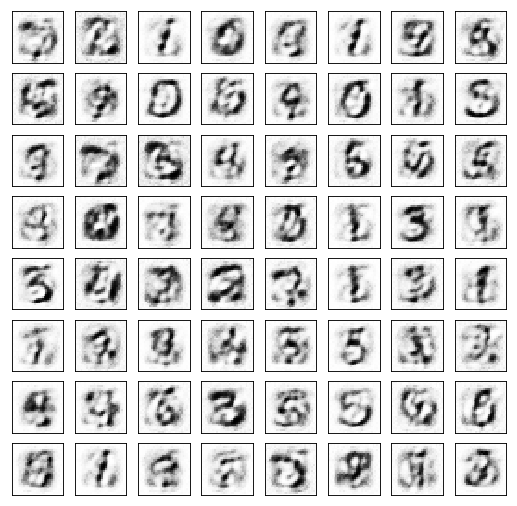

Restored from an identity matrix


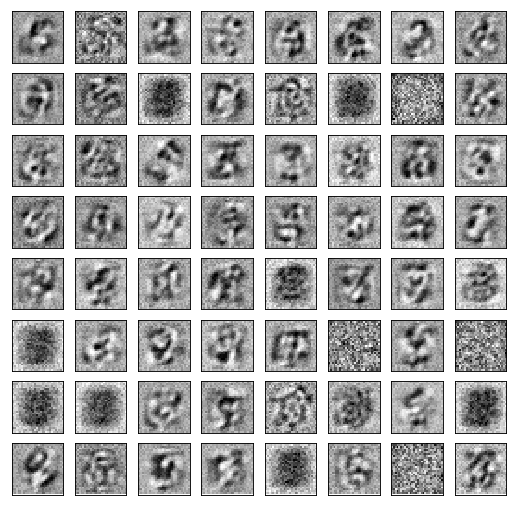

In [12]:
plot_results(next(iter(test_loader))[0], models["l1_tanh"])

In [13]:
def optimize_for_input(inp, encoder, shape=(64, 1, 28, 28)):
    """optimizes input to get an identity matrix as latent representation"""
    param = nn.Parameter(inp)
    w_optim = optim.Adam(params=[param], lr=0.01)
    
    for i in range(10001):
        w_optim.zero_grad()
        x = encoder(param.view(-1, 28*28))
        loss = F.mse_loss(x, torch.eye(shape[0]))
        if i % 1000 == 0:
            print("MSE loss: {:.4f}".format(loss.item()))
        loss.backward(retain_graph=True)
        w_optim.step()
        
    return inp

In [14]:
data = next(iter(test_loader))[0]
encoder = models["original"].E
optimized_input = optimize_for_input(data, encoder)

MSE loss: 0.0419
MSE loss: 0.0012
MSE loss: 0.0005
MSE loss: 0.0005
MSE loss: 0.0002
MSE loss: 0.0002
MSE loss: 0.0002
MSE loss: 0.0002
MSE loss: 0.0002
MSE loss: 0.0002
MSE loss: 0.0002


In [15]:
torch.isclose(encoder(optimized_input.view(-1, 28*28)), torch.eye(BATCH_SIZE), atol=1e-3, rtol=1).sum().item() / BATCH_SIZE**2

1.0

Pics that result into (almost) identity matrix at latent layer


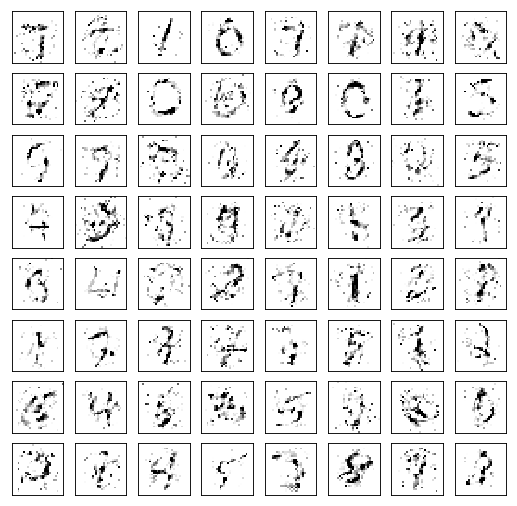

In [16]:
print("Pics that result into (almost) identity matrix at latent layer")
plot_mnist(optimized_input.view(-1, 1, 28, 28).clamp(0, 1).data.numpy(), (8, 8))

## Extra stuff

In [17]:
def train_model_with_data_modification(train_loader, valid_loader, data_modifier):

    model = Net(latent_size=BATCH_SIZE)

    for epoch in range(1, EPOCHS+1):
        model.train()
        for data, _ in train_loader:
            model.optim.zero_grad()
            modified = data_modifier(data) #torch.mul(data, noise[:len(data)])
            output = model(modified)
            rho_loss = model.rho_loss(RHO)
            loss = model.loss(output, data) + (model.l1_penalty() if model.use_l1 else rho_loss)
            loss.backward()
            model.optim.step()
            
        print("Loss on train after {} epoch: {:.4f}".format(epoch, loss.item()))
            
        model.eval()
        
        test_size = len(valid_loader.sampler)
        test_loss = 0.
        rho_loss = 0.
        with torch.no_grad():
            for data, _ in valid_loader:
                output = model(data_modifier(data))
                test_loss += model.loss(output, data, size_average=False).item()
                rho_loss += model.rho_loss(RHO, size_average=False).item()
        
        test_loss /= (test_size * 784)
        rho_loss /= (test_size * model.latent_size)    
        print("Loss on test after {} epoch: {:.4f}, rho_loss: {:.4f}\n".format(epoch, test_loss, rho_loss))
        
    return model

### Add some noise

Loss on train after 1 epoch: 0.5300
Loss on test after 1 epoch: 0.3866, rho_loss: 0.0021

Loss on train after 2 epoch: 0.3853
Loss on test after 2 epoch: 0.2892, rho_loss: 0.0016

Loss on train after 3 epoch: 0.3430
Loss on test after 3 epoch: 0.2442, rho_loss: 0.0013

Loss on train after 4 epoch: 0.2981
Loss on test after 4 epoch: 0.2173, rho_loss: 0.0011

Loss on train after 5 epoch: 0.2650
Loss on test after 5 epoch: 0.1983, rho_loss: 0.0009

Loss on train after 6 epoch: 0.2447
Loss on test after 6 epoch: 0.1814, rho_loss: 0.0008

Loss on train after 7 epoch: 0.2122
Loss on test after 7 epoch: 0.1692, rho_loss: 0.0007

Loss on train after 8 epoch: 0.2014
Loss on test after 8 epoch: 0.1577, rho_loss: 0.0006

Loss on train after 9 epoch: 0.1831
Loss on test after 9 epoch: 0.1477, rho_loss: 0.0006

Loss on train after 10 epoch: 0.1729
Loss on test after 10 epoch: 0.1400, rho_loss: 0.0005

Loss on train after 11 epoch: 0.1626
Loss on test after 11 epoch: 0.1330, rho_loss: 0.0004

Loss o

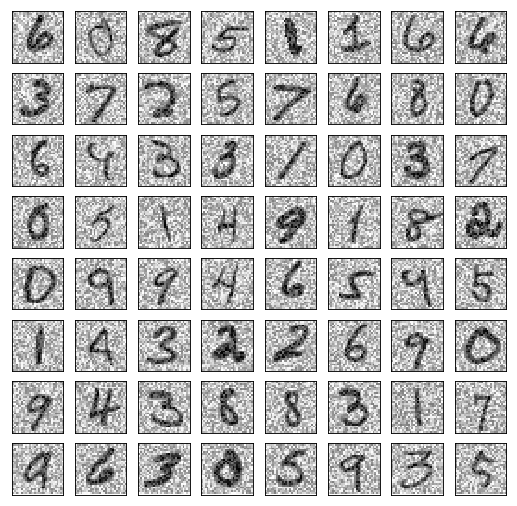

Encoded and restored


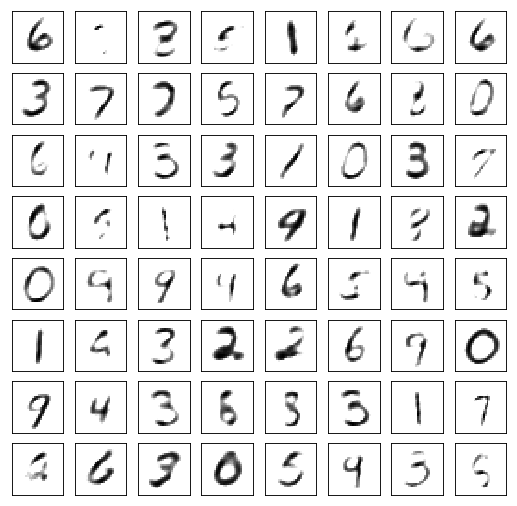

Restored with <0.5 -> 0.0 coercing after encoding


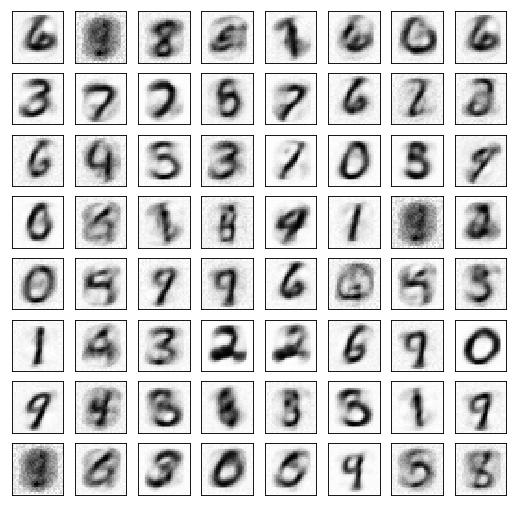

Restored from an identity matrix


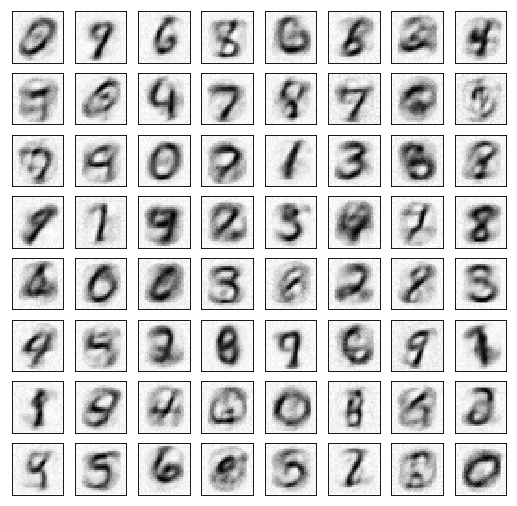

In [18]:
noise = torch.rand(BATCH_SIZE, 1, 28, 28)
add_noise = lambda data: torch.mul(data, noise[:len(data)])
noise_model = train_model_with_data_modification(train_loader, valid_loader, add_noise)
plot_results(add_noise(next(iter(train_loader))[0]), noise_model)

### Add pixel nullification

Loss on train after 1 epoch: 0.5285
Loss on test after 1 epoch: 0.3875, rho_loss: 0.0021

Loss on train after 2 epoch: 0.3896
Loss on test after 2 epoch: 0.2862, rho_loss: 0.0016

Loss on train after 3 epoch: 0.3192
Loss on test after 3 epoch: 0.2377, rho_loss: 0.0013

Loss on train after 4 epoch: 0.2803
Loss on test after 4 epoch: 0.2092, rho_loss: 0.0011

Loss on train after 5 epoch: 0.2469
Loss on test after 5 epoch: 0.1879, rho_loss: 0.0010

Loss on train after 6 epoch: 0.2282
Loss on test after 6 epoch: 0.1726, rho_loss: 0.0008

Loss on train after 7 epoch: 0.2046
Loss on test after 7 epoch: 0.1598, rho_loss: 0.0007

Loss on train after 8 epoch: 0.1872
Loss on test after 8 epoch: 0.1492, rho_loss: 0.0006

Loss on train after 9 epoch: 0.1790
Loss on test after 9 epoch: 0.1408, rho_loss: 0.0006

Loss on train after 10 epoch: 0.1680
Loss on test after 10 epoch: 0.1342, rho_loss: 0.0005

Loss on train after 11 epoch: 0.1569
Loss on test after 11 epoch: 0.1285, rho_loss: 0.0004

Loss o

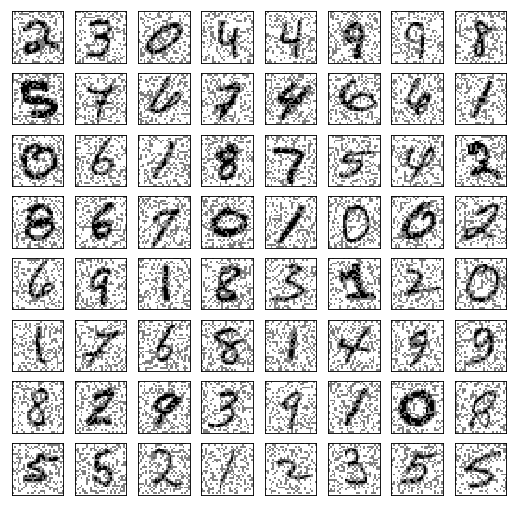

Encoded and restored


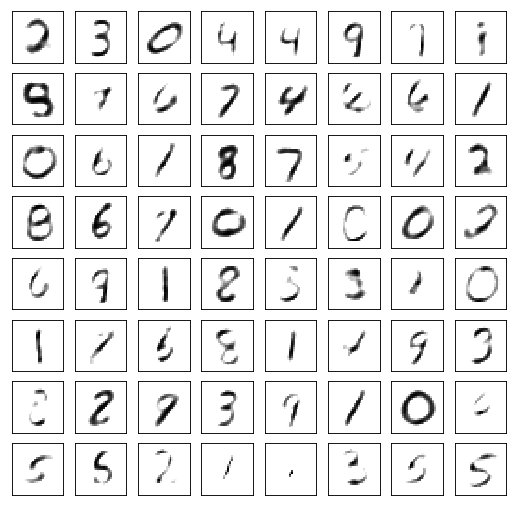

Restored with <0.5 -> 0.0 coercing after encoding


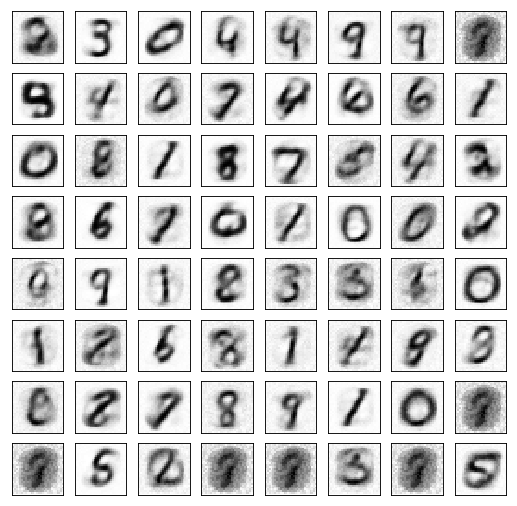

Restored from an identity matrix


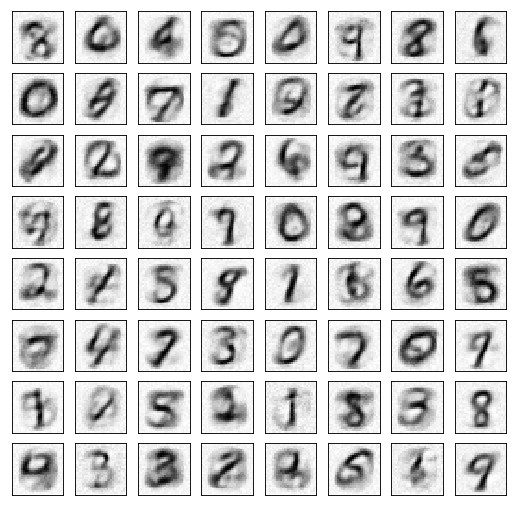

In [19]:
nullification = torch.Tensor(np.random.choice([0, 1], size=BATCH_SIZE*28*28, p=[.3, .7])).reshape(BATCH_SIZE, 1, 28, 28)
nullify = lambda data: torch.mul(data, nullification[:len(data)])
nullification_model = train_model_with_data_modification(train_loader, valid_loader, nullify)
plot_results(nullify(next(iter(train_loader))[0]), nullification_model)

### Nullify half of the picture

Loss on train after 1 epoch: 0.5178
Loss on test after 1 epoch: 0.3823, rho_loss: 0.0021

Loss on train after 2 epoch: 0.3882
Loss on test after 2 epoch: 0.2941, rho_loss: 0.0016

Loss on train after 3 epoch: 0.3363
Loss on test after 3 epoch: 0.2552, rho_loss: 0.0013

Loss on train after 4 epoch: 0.3108
Loss on test after 4 epoch: 0.2279, rho_loss: 0.0011

Loss on train after 5 epoch: 0.2611
Loss on test after 5 epoch: 0.2096, rho_loss: 0.0009

Loss on train after 6 epoch: 0.2374
Loss on test after 6 epoch: 0.1944, rho_loss: 0.0008

Loss on train after 7 epoch: 0.2291
Loss on test after 7 epoch: 0.1836, rho_loss: 0.0007

Loss on train after 8 epoch: 0.2149
Loss on test after 8 epoch: 0.1742, rho_loss: 0.0006

Loss on train after 9 epoch: 0.2015
Loss on test after 9 epoch: 0.1652, rho_loss: 0.0005

Loss on train after 10 epoch: 0.1789
Loss on test after 10 epoch: 0.1573, rho_loss: 0.0005

Loss on train after 11 epoch: 0.1751
Loss on test after 11 epoch: 0.1520, rho_loss: 0.0004

Loss o

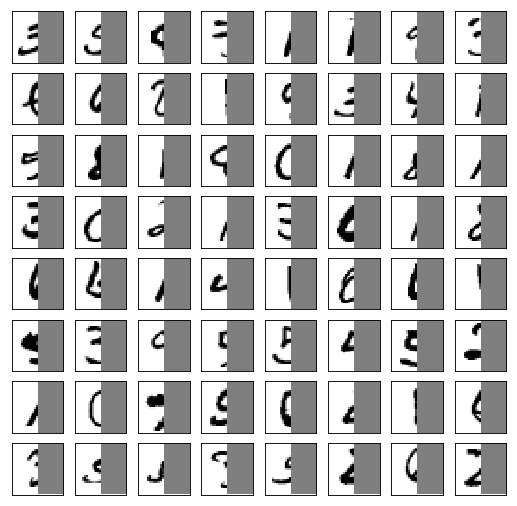

Encoded and restored


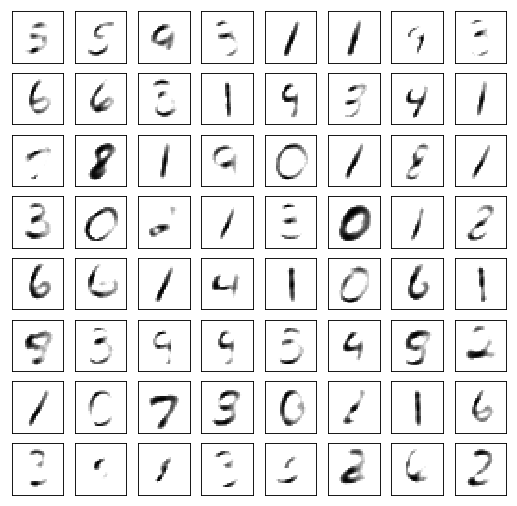

Restored with <0.5 -> 0.0 coercing after encoding


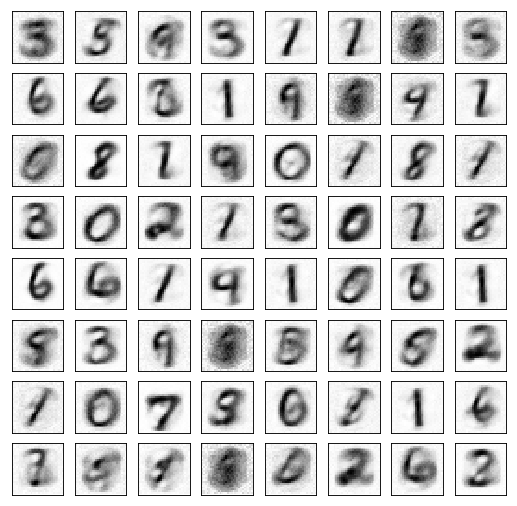

Restored from an identity matrix


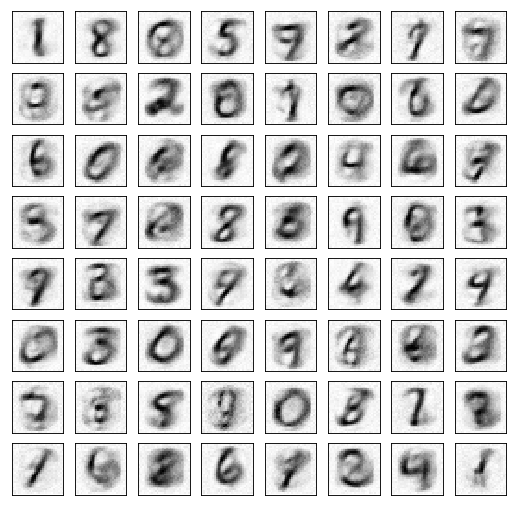

In [20]:
half_null = torch.cat((torch.ones(BATCH_SIZE, 28, 14), torch.zeros(BATCH_SIZE, 28, 14)), dim=2).reshape(BATCH_SIZE, 1, 28, 28)
half_nullify = lambda data: torch.mul(data, half_null[:len(data)])
half_nullification_model = train_model_with_data_modification(train_loader, valid_loader, half_nullify)
plot_results(half_nullify(next(iter(train_loader))[0]), half_nullification_model)

### Optimize input for classifier

In [21]:
class MnistClassifier(nn.Module):
    def __init__(self, lr=0.01):
        super(MnistClassifier, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=0.)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [22]:
def train(epoch, model, print_report=True):
    train_size = len(train_loader.sampler)
    line_format = "Train Epoch: {} [{:05d}/{} ({:.0f}%)]\tLoss: {:.6f}"
    
    for batch_idx, (data, target) in enumerate(train_loader):
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0 and print_report:
            processed = batch_idx * len(data)
            percentage = 100. * batch_idx / len(train_loader)
            line = line_format.format(epoch, processed, train_size, percentage, model._loss.item())
            print(line)
            
    else:
        batch_idx += 1
        if print_report:
            line = line_format.format(epoch, train_size, train_size, 100, model._loss.item())
            print(line)
    return model._loss.item()

In [23]:
def test(model, loader, print_report=True):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: "Loss: {:.4f}".format(l)
    acc_lambda = lambda c, p: "Accuracy: {}/{} ({:.0f}%)".format(c, test_size, p)
    line = lambda l, c, p: avg_lambda(l) + "\t" + acc_lambda(c, p)

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            test_loss += model.loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    test_loss /= test_size
    correct_pct = 100. * correct / test_size
    if print_report:
        report = "Test set:\n" + line(test_loss, correct, correct_pct) + "\n"
        print(report)
    return test_loss, correct_pct.item()

In [24]:
classifier = MnistClassifier()
message_format = "Epoch {}: train loss - {:.4f}, test loss - {:.4f}, correct_percentage - {}%"
for epoch in range(1, EPOCHS + 1):
    classifier.train()
    train_loss = train(epoch, classifier, False)
    classifier.eval()
    test_loss, correct_pct = test(classifier, valid_loader, False)
    print(message_format.format(epoch, train_loss, test_loss, correct_pct))

Epoch 1: train loss - 0.1010, test loss - 0.2635, correct_percentage - 92%
Epoch 2: train loss - 0.1738, test loss - 0.3308, correct_percentage - 90%
Epoch 3: train loss - 0.3333, test loss - 0.3158, correct_percentage - 90%
Epoch 4: train loss - 0.3431, test loss - 0.2340, correct_percentage - 93%
Epoch 5: train loss - 0.3187, test loss - 0.2493, correct_percentage - 94%
Epoch 6: train loss - 0.4794, test loss - 0.2915, correct_percentage - 91%
Epoch 7: train loss - 0.5084, test loss - 0.2932, correct_percentage - 93%
Epoch 8: train loss - 0.1363, test loss - 0.2608, correct_percentage - 93%
Epoch 9: train loss - 0.2332, test loss - 0.2731, correct_percentage - 92%
Epoch 10: train loss - 0.1794, test loss - 0.3563, correct_percentage - 91%
Epoch 11: train loss - 0.2409, test loss - 0.2974, correct_percentage - 91%
Epoch 12: train loss - 0.0692, test loss - 0.2770, correct_percentage - 93%
Epoch 13: train loss - 0.0239, test loss - 0.2411, correct_percentage - 94%
Epoch 14: train loss 

In [25]:
def optimize_classifier_input_for_target(classifier, inp, target_n):
    param = nn.Parameter(inp)
    w_optim = optim.Adam(params=[param], lr=0.01)

    target = np.zeros((BATCH_SIZE, 10))
    target[:, target_n] = 1
    target = torch.Tensor(target)

    for i in range(10001):
        w_optim.zero_grad()
        x = classifier(param.view(-1, 28*28))
        loss = F.mse_loss(x, target)
        if i % 1000 == 0:
            print("MSE loss: {:.4f}".format(loss.item()))
        loss.backward(retain_graph=True)
        w_optim.step()
    
    return inp

In [26]:
optimized_for_1 = optimize_classifier_input_for_target(classifier, torch.zeros(BATCH_SIZE, 1, 28, 28), 1)

MSE loss: 16.4066
MSE loss: 5.9786
MSE loss: 5.9801
MSE loss: 5.9785
MSE loss: 5.9790
MSE loss: 5.9792
MSE loss: 5.9863
MSE loss: 5.9806
MSE loss: 5.9785
MSE loss: 6.0050
MSE loss: 5.9787


Optimized for 1


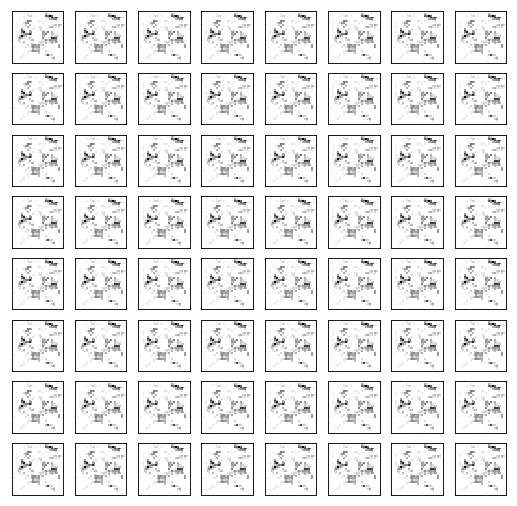

In [27]:
print("Optimized for 1")
plot_mnist(optimized_for_1.view(-1, 1, 28, 28).clamp(0, 1).data.numpy(), (8, 8))

In [28]:
torch.unique(classifier(optimized_for_1).data.max(1, keepdim=True)[1]).item()

2

In [29]:
optimized_for_8 = optimize_classifier_input_for_target(classifier, torch.zeros(BATCH_SIZE, 1, 28, 28), 8)

MSE loss: 15.6634
MSE loss: 5.9099
MSE loss: 5.9099
MSE loss: 5.9099
MSE loss: 5.9103
MSE loss: 5.9101
MSE loss: 5.9104
MSE loss: 5.9100
MSE loss: 5.9100
MSE loss: 5.9846
MSE loss: 5.9313


Optimized for 8


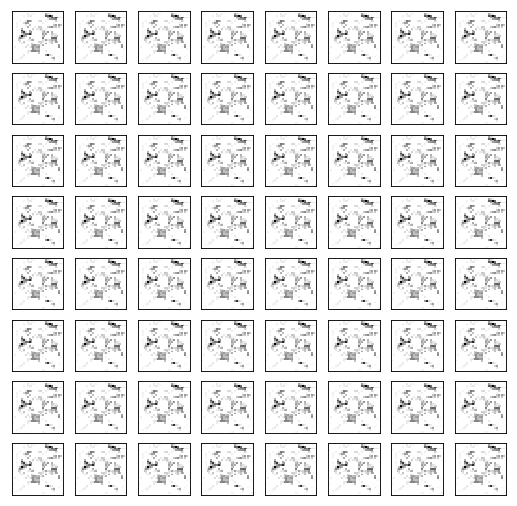

In [30]:
print("Optimized for 8")
plot_mnist(optimized_for_8.view(-1, 1, 28, 28).clamp(0, 1).data.numpy(), (8, 8))

In [31]:
torch.unique(classifier(optimized_for_8).data.max(1, keepdim=True)[1]).item()

8